<a href="https://colab.research.google.com/github/ivnlee/tec-mna-nlp/blob/main/semana-5/Equipo13_semana05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Procesamiento de Lenguaje Natural (NLP)**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales
_ _ _
### **Equipo 13**

_ _ _ 

## **Actividad Semana 5**

### **Modelos Embebidos**

### **Caso Amazon/Yelp/IMDb**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd 
import numpy as np 
import re
import string
import nltk
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer

In [ ]:
#nltk.download('omw-1.4')  

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### **1. Cargar datos**

In [6]:
# Cargamos los datos, observamos que para el archivo de IMDB 
# el separador es de 3 o más espacios y no un tabulador:

dfa = pd.read_csv('/content/drive/MyDrive/NLP/semana-5/amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi = pd.read_csv('/content/drive/MyDrive/NLP/semana-5/imdb5.txt', sep=r'\s{3,}', names=['review','label'], header=None, encoding='utf-8', engine='python')
dfy = pd.read_csv('/content/drive/MyDrive/NLP/semana-5/yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')

# verificamos total de registros
print('Total de registros Amazon: ', dfa.shape)
print('Total de registros IMDB: ', dfi.shape)
print('Total de registros Yelp: ', dfy.shape)

Total de registros Amazon:  (1000, 2)
Total de registros IMDB:  (1000, 2)
Total de registros Yelp:  (1000, 2)


In [7]:
# unimos los 3 dataframes
df = pd.concat([dfa, dfi, dfy], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


### **2. Limpieza y lematización**

In [8]:
def clean_tok(doc):
  # Elimina los signos de puntuación, caracteres especiales y números
  tokens = re.sub(r'[^A-Za-z\s]', ' ', doc).strip()

  # Elimina espacios en blanco adicionales y convierte a minúsculas
  tokens = ' '.join(re.findall(r'\b\w+\b', tokens.lower()))
  
  # Tokeniza por palabras, elimina stopwords y palabras de longitud menor a 1
  tokens = [w for w in tokens.split() if w not in stopwords.words('english') and len(w) > 1]

  return tokens

In [9]:
# Separamos las palabras de las etiquetas

X = df.review 
Y = df.label

In [10]:
# aplicamos la función clean_tok a cada registro de X

Xcleantok = [clean_tok(x) for x in X] 

Obsrvamos los primeros registros 

In [11]:
for x in Xcleantok[0:10]:
  print(x)

['way', 'plug', 'us', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tied', 'charger', 'conversations', 'lasting', 'minutes', 'major', 'problems']
['mic', 'great']
['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume']
['several', 'dozen', 'several', 'hundred', 'contacts', 'imagine', 'fun', 'sending', 'one', 'one']
['razr', 'owner', 'must']
['needless', 'say', 'wasted', 'money']
['waste', 'money', 'time']


### Lematización

Adicional a la limpieza anterior, simplificaremos el vocabulario lematizando verbos y sustantivos.

In [12]:
wnl = WordNetLemmatizer() 

def lemmatizer(doc):
  Xtmp = [wnl.lemmatize(w, 'v') for w in doc]     # lemmatiza verbos
  Xtmp = [wnl.lemmatize(w, 'n') for w in Xtmp]    # lemmatiza sustantivos
  
  return Xtmp

In [13]:
# aplicamos la función lemmatizer a cada registro de Xcleantok

Xclean = [lemmatizer(x) for x in Xcleantok]

In [14]:
for x in Xclean[0:10]:
    print(x)

['way', 'plug', 'u', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem']
['mic', 'great']
['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume']
['several', 'dozen', 'several', 'hundred', 'contact', 'imagine', 'fun', 'send', 'one', 'one']
['razr', 'owner', 'must']
['needle', 'say', 'waste', 'money']
['waste', 'money', 'time']


### **3. Train-Validation-Test split**

In [15]:
from sklearn.model_selection import train_test_split 

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
# x_train y y_train contendrán los datos de entrenamiento
# x_val_test y y_val_test contendrán los datos combinados de validación y prueba
# El parámetro test_size=0.30 indica que el 30% de los datos se utilizarán para validación y prueba
# El parámetro shuffle=True indica que los datos se mezclarán antes de dividirlos
# El parámetro random_state=42 establece una semilla aleatoria para garantizar reproducibilidad
x_train, x_val_test, y_train, y_val_test = train_test_split(Xclean, Y, test_size=0.30, shuffle=True, random_state=42)

# Dividir el conjunto de datos combinado de validación y prueba en conjuntos de validación y prueba separados
# x_val y y_val contendrán los datos de validación
# x_test y y_test contendrán los datos de prueba
# El parámetro test_size=0.50 indica que el 50% de los datos combinados se utilizarán para validación y prueba
# El parámetro shuffle=True indica que los datos se mezclarán antes de dividirlos
# El parámetro random_state=42 establece una semilla aleatoria para garantizar reproducibilidad
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.50, shuffle=True, random_state=42) 

# Verificamos el tamaño de los conjuntos de datos de entrenamiento, validación y prueba
print('X,y Train:', len(x_train), len(y_train)) 
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


### **4. Vocabulario**

In [16]:
from collections import Counter

In [17]:
diccionario = Counter()

# creamos diccionario con las palabras del set de entrenamiento
for k in range(len(x_train)):
  diccionario.update(x_train[k]) 

print('Tamaño del diccionario: ', len(diccionario))

Tamaño del diccionario:  3292


In [18]:
# filtramos el diccionario
frec_min = 1

dicc = {k:v for k,v in diccionario.items() if v > frec_min}

print('Tamaño del diccionario filtrado: ', len(dicc))

Tamaño del diccionario filtrado:  1440


### Filtramos los conjuntos de datos de entrenamiento, validación y prueba

In [19]:
train_x = []
for n in x_train:
    train_x.append([w for w in n if w in dicc])

val_x = []
for n in x_val:
    val_x.append([w for w in n if w in dicc])

test_x = []
for n in x_test:
    test_x.append([w for w in n if w in dicc])

* **1) ¿Por qué es importante acotar un vocabulario inferior y superiormente?**
Es importante generar una acotación de diccionario por los siguientes motivos:
Eficiencia en los recursos computacionales: en todos los escenarios los recursos son finitos y utilizar un vocabulario muy grande puede aumentar de manera drástica el tiempo de procesamiento y los recursos requeridos para poder entrenar modelos, limitando el tamaño del vocabulario, ayuda a tener buenos rendimientos computacionales.
Palabras focalizadas: al acotar los vocabularios, el modelo se enfoca solo en las palabras más relevantes y frecuentes, eliminando las palabras menos comunes y frecuentas, se evita que el modelo sufra sobreajustes por patrones que podrían introducir estos outlayers.
Eliminación de ruido (error): con la acotación del vocabulario, se eliminan palabras que podrían introducir error en el modelo, esto puede mejorar la calidad y precisión del modelo.

* **2) ¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario?**
Generalmente, se usa el modelo de entrenamiento para evitar sesgo en los datos, al usar solo esto el modelo tiene acceso a palabras y features presentes en este conjunto, lo que potencialmente refleja lo que necesitamos utilizar.
Si se utilizara el conjunto de validación o de prueba, se podría introducir información sobre palabras que solo existan en estos conjuntos, lo que podría potencialmente sesgar de manera importante el modelo, ya que éste tendría acceso a palabras y features que no debería conocer en el entrenamiento. El objetivo es que el modelo aprenda desde el entrenamiento y, con base en este conocimiento, pueda aplicarlo a cosas que no conoce en los conjuntos de validación y prueba


### **5. Tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford.**

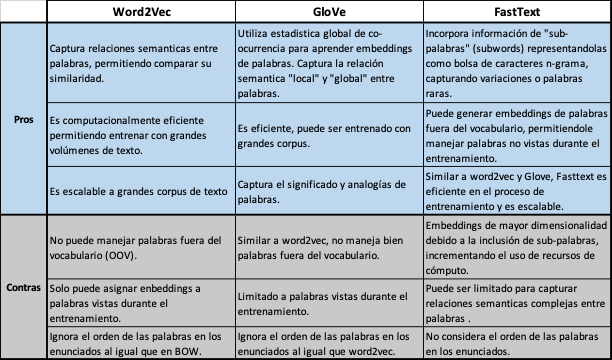

### **6. Diccionario con Vectores Embebidos de FastText**

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393248 sha256=7bf195432539ad65ec05fff11377b6b29c9dee35874b802f0e6d7126bae26e89
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util

In [ ]:
# Descargamos el modelo de idioma 'en' (inglés) si aún no está descargado
# La función download_model() del módulo fasttext.util se encarga de descargar y almacenar el modelo
# El parámetro 'en' indica el idioma del modelo que se desea descargar
# El parámetro if_exists='ignore' evita que se descargue el modelo si ya está presente en el sistema
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [ ]:
# Cargamos un modelo pre-entrenado de FastText en inglés
# Utilizamos la función load_model() del módulo fasttext para cargar el modelo
# El parámetro 'cc.en.300.bin' especifica el nombre del archivo que contiene el modelo pre-entrenado
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
len(ft.words)

In [ ]:
ft.get_dimension()

In [ ]:
midicc = {}

# extraemos los vectores embebidos para nuestro diccionario
for k,w in enumerate(dicc.keys()):
  tmp = ft.get_word_vector(w)
  midicc.update({w:tmp})


### Guardamos el diccionario en un archivo pickle

In [20]:
import pickle

#with open('midicc_emb.pickle', 'wb') as f:
#    pickle.dump(midicc, f, protocol=pickle.HIGHEST_PROTOCOL)

### para cargar nuevamente el archivo usamos el siguiente codigo: ###
with open('/content/drive/MyDrive/NLP/semana-5/midicc_emb.pickle', 'rb') as f:
    midicc = pickle.load(f)

### Verificamos que el nuevo diccionario con vectores embebidos sea del mismo tamaño de nuestro vocabulario:

In [21]:
print(len(dicc) == len(midicc))

True


In [ ]:
# borramos la variable ft para liberar memoria RAM
#del ft 

### **7. Asignar a cada comentario filtrado el vector embebido de dimensión 300**

In [22]:
def embedding_vector(docs):
    '''Función para asignar el vector embebido de dimensión 300
       promediando los tokens de cada comentario
    '''  
    dim = 300
    zero_vector = np.zeros(dim)
    vectors = []
# Iteramos sobre los comentarios en `docs` para asignar el vector embebido a cada uno
    for tokens in docs:
        tmp_vect =  np.zeros(dim)
        tmp_count = 0 + 1e-5      # para evitar dividir por 0

        # Iteramos sobre los tokens de cada comentario para obtener sus vectores embebidos
        for token in tokens:
            if token in midicc:
                tmp_vect += midicc[token]
                tmp_count += 1

        # Verificamos si hay algún token en el comentario
        # Si sí, calculamos el promedio del vector embebido de los tokens presentes
        # Si no, asignamos un vector de ceros
        if(tmp_count != 0):
            vectors.append(tmp_vect / tmp_count) 
        else:
            vectors.append(zero_vector)

    return vectors


In [23]:
# creamos los nuevos sets de entrenamiento, validacion y prueba

trainEmb = embedding_vector(train_x) 

valEmb = embedding_vector(val_x)

testEmb = embedding_vector(test_x) 

In [24]:
print('X Train: ', len(trainEmb))
print('X Val: ', len(valEmb))
print('X Test: ', len(testEmb))

X Train:  2100
X Val:  450
X Test:  450


In [25]:
print(len(trainEmb[1]))
print(len(valEmb[1]))
print(len(testEmb[1]))

300
300
300


**7a. Conjuntos de entrenamiento, validación y prueba:**
* **1) ¿Cuales son sus dimensiones?**

    ` trainEmb `  : 2100 vectores
    
    ` valEmb ` : 450 vectores

    ` testEmb ` : 450 vectores

    Cada vector de cada conjunto tiene 300 componentes o dimensiones.

* **2) ¿Se podrían usar para
su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?**

    Al contrario de las matrices Tf-idf, los modelos de vectores embebidos generan vectores densos, es decir, casi no tienen valores iguales a 0. Por lo tanto no se podrían representar con matrices dispersas.




### **8. Modelos de Regresión Logística y Random Forest**

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Creación y entrenamiento de un modelo de regresión logística con embeddings
modeloLRemb = LogisticRegression(max_iter=1000, C=1.9, solver='liblinear', random_state=42)
modeloLRemb.fit(trainEmb, y_train)

# Creación y entrenamiento de un modelo de clasificación de bosques aleatorios con embeddings
modeloRFemb = RandomForestClassifier(n_estimators=9, max_depth=4, random_state=42)
modeloRFemb.fit(trainEmb, y_train)

########################################################################################

# Evaluación de los modelos en el conjunto de entrenamiento y validación utilizando la precisión (accuracy)
# Regresión logística
print('LR: Train-accuracy: %.2f%%' % (100*modeloLRemb.score(trainEmb, y_train)))
print('LR: Val-accuracy: %2.f%%' % (100*modeloLRemb.score(valEmb, y_val)))

# Bosques aleatorios
print('\nRF: Train-accuracy: %.2f%%' % (100*modeloRFemb.score(trainEmb, y_train)))
print('RF: Val-accuracy: %.2f%%' % (100*modeloRFemb.score(valEmb, y_val)))

LR: Train-accuracy: 81.05%
LR: Val-accuracy: 77%

RF: Train-accuracy: 80.29%
RF: Val-accuracy: 70.00%


### **9. Matriz de Confusión**

Elegimos como mejor modelo el de Regresión Logística

In [28]:
from sklearn.metrics import confusion_matrix 

In [29]:
# Evaluación del mejor modelo de regresión logística en el conjunto de prueba
print('Test-accuracy con el mejor modelo: %.2f%%' % (100*modeloLRemb.score(testEmb, y_test))) 

# Realizamos predicciones en el conjunto de prueba utilizando el mejor modelo
pred = modeloLRemb.predict(testEmb)

# Imprimimos la matriz de confusión utilizando el mejor modelo
print('\nMatriz de confusión con el mejor modelo:')
print(confusion_matrix(y_test, pred, labels=[0,1]))

# Imprimimos la matriz de confusión en proporciones utilizando el mejor modelo
print('\nMatriz de confusión con el mejor modelo en proporciones:')
print(confusion_matrix(y_test, pred, labels=[0,1]) / pred.shape[0])

Test-accuracy con el mejor modelo: 79.56%

Matriz de confusión con el mejor modelo:
[[170  47]
 [ 45 188]]

Matriz de confusión con el mejor modelo en proporciones:
[[0.37777778 0.10444444]
 [0.1        0.41777778]]


### Interpretación matriz de confusión

En el mejor obtenido se tiene la siguiente información de la matriz de confusión:
*	Verdaderos positivos (True Positives, TP): 170
*	Falsos positivos (False Positives, FP): 47
*	Falsos negativos (False Negatives, FN): 45
*	Verdaderos negativos (True Negatives, TN): 188

Entonces, se puede decir que el modelo hizo la predicción correcta de 170 casos positivos, clasificó 47 casos de manera errónea como positivos cuando en verdad son negativos, clasifico 45 casos negativos cuando eran positivos y clasificó 188 casos negativos de manera correcta.

Con estos valores se puede realizar una evaluación de la precisión y rendimiento del modelo, en este caso, el modelo tiene una precisión de casi el 80% en la base de datos de pruebas. También, existen todavía algunos errores en falsos positivos y negativos.

Se debe tener en cuenta el contexto de la información para determinar los impactos que podrían tener en el negocio, si esta fuera información relevante respecto a temas de salud, un falso positivo tendría un impacto devastador.


### **10. Conclusiones finales**

Finalmente, se puede decir que la actividad semanal se basó en le uso de vectores incrustados de FastText para clasificar textos. Adicional a todo el procesamiento de datos para poder realizar las particiones y las evaluaciones de modelos, destaca la importancia de crear vocabularios bien definidos, ya que ayuda a limitar la dimensionalidad de los datos y a reducir el sobreajuste de los modelos; el vocabulario se generó únicamente usando el conjunto de entrenamiento, con lo que aseguramos que el modelo aprendiera de un conjunto consistente de palabras.

Con esta actividad se pudo demostrar la importancia de implementar diversas metodologías para buscar modelos que permitan mejorar la precisión. Una posible conclusión es que el modelo está capturando el ruido o características irrelevantes en los datos de entrenamiento, lo que resulta en una alta precisión en el conjunto de entrenamiento pero una precisión más baja en el conjunto de validación. Esto indica una falta de generalización del modelo.

Es importante tener en cuenta que la precisión obtenida en el conjunto de validación es un indicador más confiable del rendimiento del modelo en datos no vistos. Si la diferencia entre la precisión del conjunto de entrenamiento y el conjunto de validación es significativa, puede ser necesario revisar el modelo y aplicar técnicas como la regularización, el ajuste de parámetros o el aumento de datos para mejorar la generalización y reducir el sobreajuste. El uso de vectores incrustados permitió la incorporación de información contextual, lo que mejora el modelo.


### 11. Modelado con XGBoost

In [30]:
!pip install xgboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import xgboost as xgb

In [67]:
modeloXGBemb = xgb.XGBClassifier(max_depth=4, n_estimators=1000, reg_lambda=1.5,
                                 early_stopping_rounds=50 ,eval_metric='auc', eta=0.01)

modeloXGBemb.fit(trainEmb, y_train, eval_set=[(trainEmb, y_train), (valEmb, y_val)], verbose=100)

[0]	validation_0-auc:0.80618	validation_1-auc:0.69951
[100]	validation_0-auc:0.94353	validation_1-auc:0.81106
[200]	validation_0-auc:0.96667	validation_1-auc:0.81887
[300]	validation_0-auc:0.97958	validation_1-auc:0.82559
[400]	validation_0-auc:0.98678	validation_1-auc:0.83077
[500]	validation_0-auc:0.99127	validation_1-auc:0.83573
[600]	validation_0-auc:0.99417	validation_1-auc:0.83899
[640]	validation_0-auc:0.99496	validation_1-auc:0.83858


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eta=0.01, eval_metric='auc',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [68]:
print('XGB: Train-accuracy: %.2f%%' % (100*modeloXGBemb.score(trainEmb, y_train)))
print('XGB: Val-accuracy: %2.f%%' % (100*modeloXGBemb.score(valEmb, y_val)))

XGB: Train-accuracy: 96.76%
XGB: Val-accuracy: 73%


In [69]:
print('Test-accuracy con el modelo XGBoost: %.2f%%' % (100*modeloXGBemb.score(testEmb, y_test))) 

# Realizamos predicciones en el conjunto de prueba utilizando el mejor modelo
pred = modeloXGBemb.predict(testEmb)

# Imprimimos la matriz de confusión utilizando el mejor modelo
print('\nMatriz de confusión con el modelo XGBoost:')
print(confusion_matrix(y_test, pred, labels=[0,1]))

# Imprimimos la matriz de confusión en proporciones utilizando el mejor modelo
print('\nMatriz de confusión con el modelo XGBoost en proporciones:')
print(confusion_matrix(y_test, pred, labels=[0,1]) / pred.shape[0])

Test-accuracy con el modelo XGBoost: 80.00%

Matriz de confusión con el modelo XGBoost:
[[169  48]
 [ 42 191]]

Matriz de confusión con el modelo XGBoost en proporciones:
[[0.37555556 0.10666667]
 [0.09333333 0.42444444]]
